In [85]:
using Plots

Plots.gr();

13×13 Matrix{Float64}:
 0.0  0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0
 0.0  0.0    0.0    0.0    0.001  0.002  0.002  0.002  0.001  0.0    0.0    0.0    0.0
 0.0  0.0    0.0    0.002  0.007  0.014  0.018  0.014  0.007  0.002  0.0    0.0    0.0
 0.0  0.0    0.002  0.011  0.039  0.082  0.105  0.082  0.039  0.011  0.002  0.0    0.0
 0.0  0.001  0.007  0.039  0.135  0.287  0.368  0.287  0.135  0.039  0.007  0.001  0.0
 0.0  0.002  0.014  0.082  0.287  0.607  0.779  0.607  0.287  0.082  0.014  0.002  0.0
 0.0  0.002  0.018  0.105  0.368  0.779  1.0    0.779  0.368  0.105  0.018  0.002  0.0
 0.0  0.002  0.014  0.082  0.287  0.607  0.779  0.607  0.287  0.082  0.014  0.002  0.0
 0.0  0.001  0.007  0.039  0.135  0.287  0.368  0.287  0.135  0.039  0.007  0.001  0.0
 0.0  0.0    0.002  0.011  0.039  0.082  0.105  0.082  0.039  0.011  0.002  0.0    0.0
 0.0  0.0    0.0    0.002  0.007  0.014  0.018  0.014  0.007  0.002  0.0    0.0    0.0
 0.0  0.0    0.0    

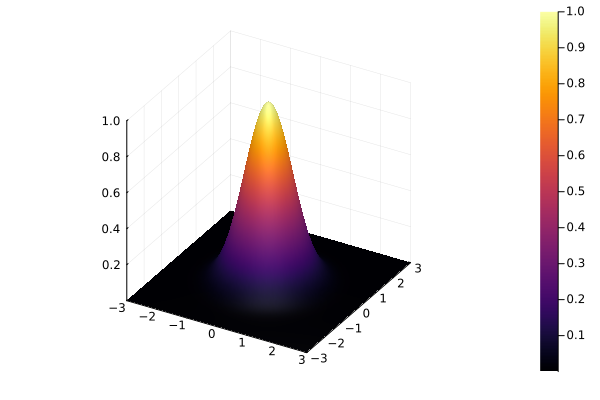

In [89]:
# Basic terrain cost field for initial pathing tests

basicTerrain(x, y) = exp(-1(x^2 + y^2))

# Interpret as going from -size to size in resolution steps
size = 3
resolution = 2

# Generate discrete field
discreteField = zeros(size * resolution * 2 + 1, size * resolution * 2 + 1)

for i in 1:resolution*size*2+1
  for j in 1:resolution*size*2+1
    
    # Rearange axis
    x = (i - resolution * size - 1) / resolution
    y = (j - resolution * size - 1) / resolution
    discreteField[i,j] = round(basicTerrain(x,y), digits=3)
  
  end
end

# Show graph
#Sshow(stdout, "text/plain", discreteField)

f(x, y) = sin(x) + cos(y)
surface(-size:0.1/resolution:size, -size:0.1/resolution:size, basicTerrain)